In this notebook, we will be using various machine learning models to predict test scores(A, B, C, D, or, F) based off of various factors. We will start with data preprocessing to make sure our data is ready to be split and run into our models. We will then use hyperparametertuning to choose the best model for predictions.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import VotingClassifier
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# Read data
df = pd.read_csv("StudentPerformanceFactors.csv", true_values = ['Yes'], false_values = ['No'])
display(df.head())
print(df.shape)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,False,7,73,Low,True,0,Low,Medium,Public,Positive,3,False,High School,Near,Male,67
1,19,64,Low,Medium,False,8,59,Low,True,2,Medium,Medium,Public,Negative,4,False,College,Moderate,Female,61
2,24,98,Medium,Medium,True,7,91,Medium,True,2,Medium,Medium,Public,Neutral,4,False,Postgraduate,Near,Male,74
3,29,89,Low,Medium,True,8,98,Medium,True,1,Medium,Medium,Public,Negative,4,False,High School,Moderate,Male,71
4,19,92,Medium,Medium,True,6,65,Medium,True,3,Medium,High,Public,Neutral,4,False,College,Near,Female,70


(6607, 20)


In [3]:
# Data types
print(df.info())

print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   bool  
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   bool  
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

As we can see from above, some of our variables are numerical and some are categorical/boolean. However, some of the "numeric" variables such as "Sleep_Hours", "Tutoring_Sessions", and "Physical_Activity" act more as categorical variables as they don't have a continuous range and fall into specific categories. Let us demonstrate this by plotting histograms for these factors.

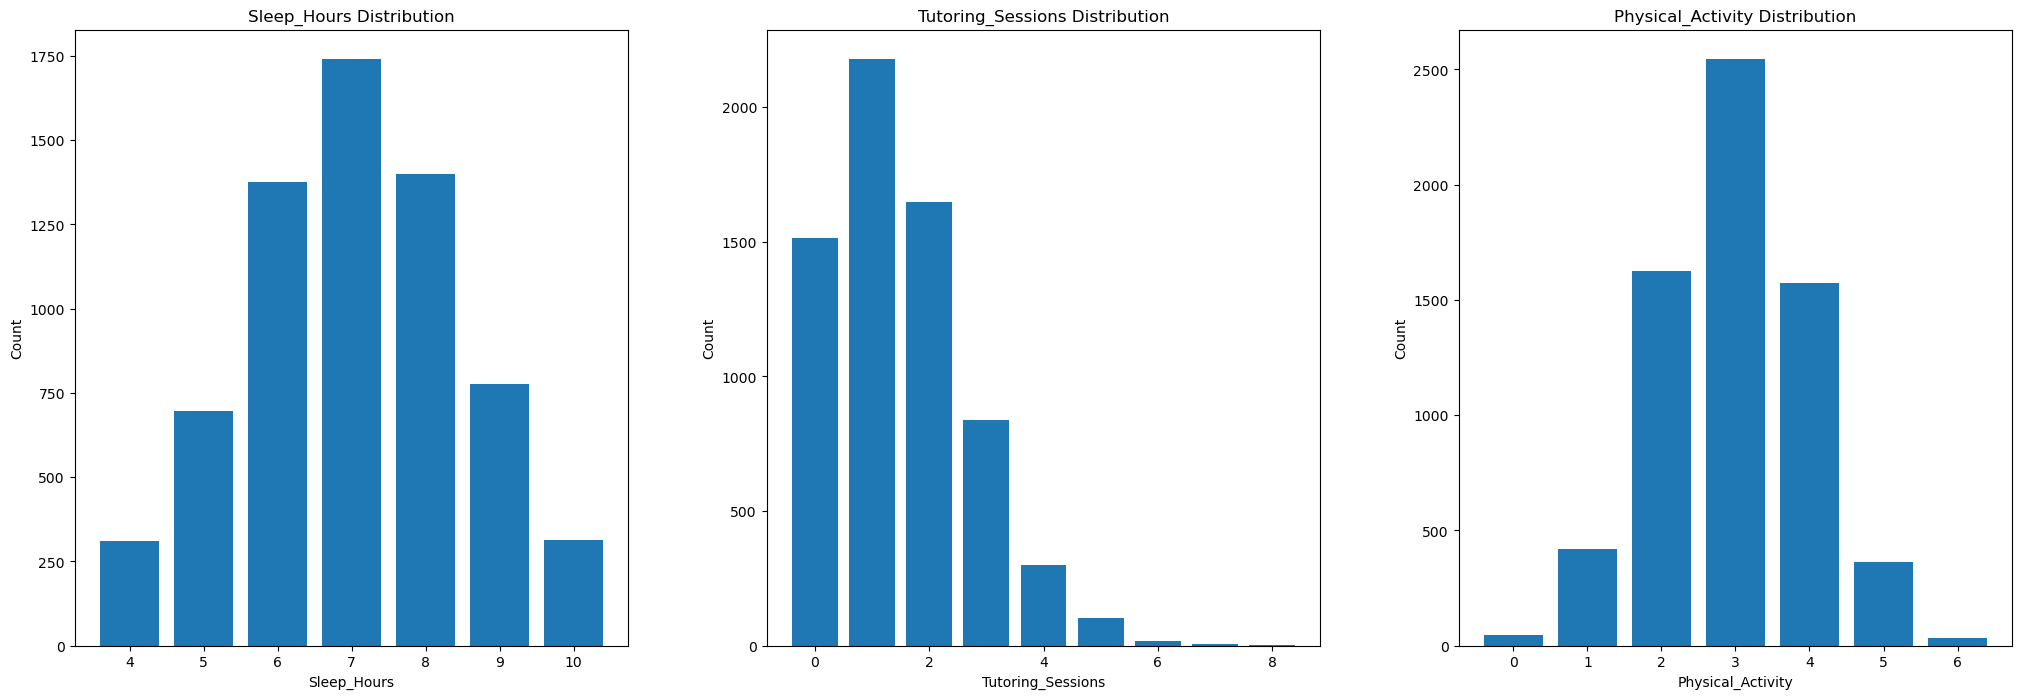

In [4]:
# Create a list of vars, print out value_counts, and plot the distribution
num_cat_vars = ["Sleep_Hours", "Tutoring_Sessions", "Physical_Activity"]
fig, ax = plt.subplots(1,3, figsize = (25, 8))

for i, num_cat_var in enumerate(num_cat_vars):
    ax[i].bar(df[num_cat_var].value_counts().index, df[num_cat_var].value_counts())
    ax[i].set_xlabel(num_cat_var)
    ax[i].set_ylabel("Count")
    ax[i].set_title(f"{num_cat_var} Distribution")

plt.subplots_adjust(wspace=0.25)

As we can see, this variables and distributed in categories, so we will treat them as such. Our next task is to discretize or traget variable, test_score to determine if they will get an A, B, C, D, or F, and then we can plot the distributions

In [5]:
print(df["Exam_Score"])

0       67
1       61
2       74
3       71
4       70
        ..
6602    68
6603    69
6604    68
6605    68
6606    64
Name: Exam_Score, Length: 6607, dtype: int64


In [6]:
df["Exam_Score"] = pd.cut(df["Exam_Score"], bins = [0, 60, 70, 80, 90, 100], labels = ['F', 'D', 'C', 'B', 'A'])
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,False,7,73,Low,True,0,Low,Medium,Public,Positive,3,False,High School,Near,Male,D
1,19,64,Low,Medium,False,8,59,Low,True,2,Medium,Medium,Public,Negative,4,False,College,Moderate,Female,D
2,24,98,Medium,Medium,True,7,91,Medium,True,2,Medium,Medium,Public,Neutral,4,False,Postgraduate,Near,Male,C
3,29,89,Low,Medium,True,8,98,Medium,True,1,Medium,Medium,Public,Negative,4,False,High School,Moderate,Male,C
4,19,92,Medium,Medium,True,6,65,Medium,True,3,Medium,High,Public,Neutral,4,False,College,Near,Female,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,False,7,76,Medium,True,1,High,Medium,Public,Positive,2,False,High School,Near,Female,D
6603,23,76,High,Medium,False,8,81,Medium,True,3,Low,High,Public,Positive,2,False,High School,Near,Female,D
6604,20,90,Medium,Low,True,6,65,Low,True,3,Low,Medium,Public,Negative,2,False,Postgraduate,Near,Female,D
6605,10,86,High,High,True,6,91,High,True,2,Low,Medium,Private,Positive,3,False,High School,Far,Female,D


,Exam_Score,count
4,A,21
3,B,21
1,C,1040
0,D,5379
2,F,145


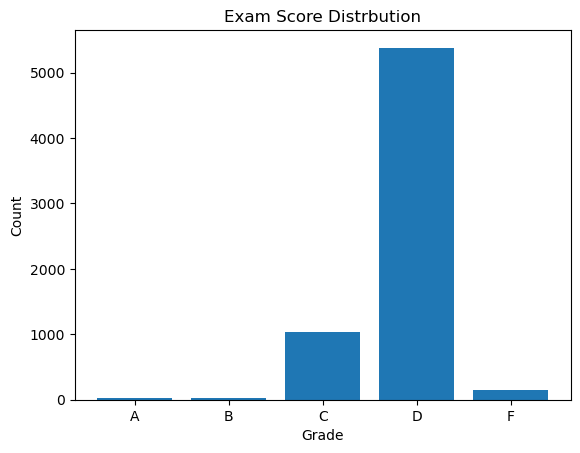

In [7]:
# Store value counts into temp df, and then change index to sort index for bar plot
temp_score_df = df["Exam_Score"].value_counts().to_frame().reset_index().sort_values(by = "Exam_Score", ascending = False)

display(temp_score_df)

# Plot value counts 
plt.bar(temp_score_df["Exam_Score"], temp_score_df["count"])
plt.title("Exam Score Distrbution")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

Wow! Seems like that was a really hard test with the mast majority getting C's and D's with only 42 students getting A's and B's. How lets preprocess out data such as our categorical data to get ready for ML.

In [8]:
# Loop through columns to check dtype to make appropriate adjustments
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype('int64') # Change bools to numeric 0 and 1 values

    # If the column is categorical, transform the column using dummy variables, and concat with original df
    elif df[col].dtype == object or col in ["Sleep_Hours", "Tutoring_Sessions", "Physical_Activity"]:
        temp = pd.get_dummies(df[col], prefix = f"{col}_", drop_first = True).astype('int64')
        df = pd.concat([df, temp], axis = 1)
        del(df[col])


# # Reorder df, so exam_score is the last column shown
exam_col = df['Exam_Score']
del(df["Exam_Score"])
df["Exam_Score"] = exam_col


display(df.head())
print(df.shape)

df.isna().sum()

,Hours_Studied,Attendance,Extracurricular_Activities,Previous_Scores,Internet_Access,Learning_Disabilities,Parental_Involvement__Low,Parental_Involvement__Medium,Access_to_Resources__Low,Access_to_Resources__Medium,...,Physical_Activity__3,Physical_Activity__4,Physical_Activity__5,Physical_Activity__6,Parental_Education_Level__High School,Parental_Education_Level__Postgraduate,Distance_from_Home__Moderate,Distance_from_Home__Near,Gender__Male,Exam_Score
0,23,84,0,73,1,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,D
1,19,64,0,59,1,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,D
2,24,98,1,91,1,0,0,1,0,1,...,0,1,0,0,0,1,0,1,1,C
3,29,89,1,98,1,0,1,0,0,1,...,0,1,0,0,1,0,1,0,1,C
4,19,92,1,65,1,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,D


(6607, 45)


Hours_Studied                             0
Attendance                                0
Extracurricular_Activities                0
Previous_Scores                           0
Internet_Access                           0
Learning_Disabilities                     0
Parental_Involvement__Low                 0
Parental_Involvement__Medium              0
Access_to_Resources__Low                  0
Access_to_Resources__Medium               0
Sleep_Hours__5                            0
Sleep_Hours__6                            0
Sleep_Hours__7                            0
Sleep_Hours__8                            0
Sleep_Hours__9                            0
Sleep_Hours__10                           0
Motivation_Level__Low                     0
Motivation_Level__Medium                  0
Tutoring_Sessions__1                      0
Tutoring_Sessions__2                      0
Tutoring_Sessions__3                      0
Tutoring_Sessions__4                      0
Tutoring_Sessions__5            

Now that we have preprocessed the data, we our ready to split our data, but before, lets drop the one row of data missing an exam score.

In [9]:
#Drop row 
df.dropna(inplace=True)

# Define features(x) and traget(y)
X = df[df.columns[:-1]]
y = df["Exam_Score"]

# Split data on X and Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# Print test and training data
print("**********************************X Train**********************************")
display(X_train.head())
print()

print("**********************************X Test**********************************")
display(X_test.head())
print()

print("**********************************Y Train**********************************")
display(y_train.head())
print(y_train.value_counts(normalize=True))
print()

print("**********************************Y Test**********************************")
display(y_test.head())
print(y_test.value_counts(normalize=True))

**********************************X Train**********************************


,Hours_Studied,Attendance,Extracurricular_Activities,Previous_Scores,Internet_Access,Learning_Disabilities,Parental_Involvement__Low,Parental_Involvement__Medium,Access_to_Resources__Low,Access_to_Resources__Medium,...,Physical_Activity__2,Physical_Activity__3,Physical_Activity__4,Physical_Activity__5,Physical_Activity__6,Parental_Education_Level__High School,Parental_Education_Level__Postgraduate,Distance_from_Home__Moderate,Distance_from_Home__Near,Gender__Male
3155,10,77,0,84,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1449,20,92,1,89,1,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4968,18,95,1,54,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
5466,22,63,1,54,1,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,1
5362,20,70,0,64,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1



**********************************X Test**********************************


,Hours_Studied,Attendance,Extracurricular_Activities,Previous_Scores,Internet_Access,Learning_Disabilities,Parental_Involvement__Low,Parental_Involvement__Medium,Access_to_Resources__Low,Access_to_Resources__Medium,...,Physical_Activity__2,Physical_Activity__3,Physical_Activity__4,Physical_Activity__5,Physical_Activity__6,Parental_Education_Level__High School,Parental_Education_Level__Postgraduate,Distance_from_Home__Moderate,Distance_from_Home__Near,Gender__Male
2635,26,83,1,89,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
5524,15,79,1,66,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3877,21,75,0,70,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4145,4,83,0,99,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
5509,19,65,0,58,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0



**********************************Y Train**********************************


3155    D
1449    D
4968    D
5466    D
5362    D
Name: Exam_Score, dtype: category
Categories (5, object): ['F' < 'D' < 'C' < 'B' < 'A']

Exam_Score
D    0.814230
C    0.157439
F    0.021843
B    0.003244
A    0.003244
Name: proportion, dtype: float64

**********************************Y Test**********************************


2635    C
5524    D
3877    D
4145    D
5509    D
Name: Exam_Score, dtype: category
Categories (5, object): ['F' < 'D' < 'C' < 'B' < 'A']

Exam_Score
D    0.814329
C    0.157417
F    0.022200
B    0.003027
A    0.003027
Name: proportion, dtype: float64


For this notebook, we will be using 5 models aswell as well as RandomSearchCV to find the best model.


FINISH THIS


In [10]:
# Create a dictionary for the models we will use
models = {
    "logreg": LogisticRegression(),
    "knn": KNeighborsClassifier(),
    "svc": SVC(),
    "decision_tree": DecisionTreeClassifier(),
    "sgd": SGDClassifier()
}

# Create parameter grid for each model
model_params = {
    "logreg": {
        'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logreg__multi_class': ['auto', 'multinomial']
    },
    
    "knn": {
        'knn__n_neighbors': [_ for _ in range(3,16)],
        'knn__weights': ['uniform', 'distance']
    },
    
    "svc": {
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'svc__gamma': ['scale', 'auto']
    },

    "decision_tree": {
        'decision_tree__max_depth': [3, 6, 9, 12, 15],
        'decision_tree__random_state' : [42]
    },

    'sgd': {
        'sgd__alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
        'sgd__loss':['log_loss', 'hinge'],
        'sgd__random_state':[42]
    }
}

1 LogisticRegression()


C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__multi_class,param_logreg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.066746,0.009200,0.003656,0.000764,multinomial,10.0,"{'logreg__multi_class': 'multinomial', 'logreg...",0.970811,0.981622,0.975135,0.969730,0.967532,0.972966,0.004985,1
5,0.079309,0.008105,0.005063,0.000481,auto,10.0,"{'logreg__multi_class': 'auto', 'logreg__C': 10}",0.970811,0.981622,0.975135,0.969730,0.967532,0.972966,0.004985,1
1,0.070410,0.013802,0.003535,0.000598,multinomial,100.0,"{'logreg__multi_class': 'multinomial', 'logreg...",0.968649,0.981622,0.974054,0.968649,0.967532,0.972101,0.005276,3
3,0.079069,0.013651,0.003724,0.000984,auto,1000.0,"{'logreg__multi_class': 'auto', 'logreg__C': 1...",0.968649,0.980541,0.972973,0.970811,0.966450,0.971885,0.004843,4
8,0.090865,0.007222,0.004384,0.001162,multinomial,1000.0,"{'logreg__multi_class': 'multinomial', 'logreg...",0.968649,0.980541,0.972973,0.970811,0.966450,0.971885,0.004843,4


Best model parameters for logreg: {'logreg__multi_class': 'multinomial', 'logreg__C': 10}
Best score: 0.973

2 KNeighborsClassifier()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__weights,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.016284,0.002927,0.018102,0.002256,distance,8,"{'knn__weights': 'distance', 'knn__n_neighbors...",0.802162,0.836757,0.825946,0.836757,0.836580,0.827640,0.013403,1
8,0.018104,0.007228,0.015813,0.006274,distance,14,"{'knn__weights': 'distance', 'knn__n_neighbors...",0.801081,0.833514,0.824865,0.842162,0.832251,0.826775,0.013971,2
6,0.013993,0.007835,0.016556,0.002603,distance,9,"{'knn__weights': 'distance', 'knn__n_neighbors...",0.795676,0.838919,0.821622,0.836757,0.834416,0.825478,0.016067,3
5,0.014153,0.005490,0.015650,0.000654,distance,7,"{'knn__weights': 'distance', 'knn__n_neighbors...",0.796757,0.833514,0.821622,0.835676,0.836580,0.824830,0.015030,4
0,0.013273,0.000554,0.107071,0.109733,uniform,7,"{'knn__weights': 'uniform', 'knn__n_neighbors'...",0.796757,0.834595,0.820541,0.832432,0.837662,0.824397,0.014989,5


Best model parameters for knn: {'knn__weights': 'distance', 'knn__n_neighbors': 8}
Best score: 0.8276

3 SVC()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.414531,0.010554,0.173768,0.023921,auto,10.0,"{'svc__gamma': 'auto', 'svc__C': 10}",0.928649,0.949189,0.920000,0.950270,0.946970,0.939016,0.012349,1
5,0.553530,0.113959,0.246443,0.059209,scale,10.0,"{'svc__gamma': 'scale', 'svc__C': 10}",0.928649,0.948108,0.920000,0.950270,0.946970,0.938799,0.012177,2
1,0.431392,0.068074,0.216648,0.050459,auto,100.0,"{'svc__gamma': 'auto', 'svc__C': 100}",0.927568,0.949189,0.917838,0.945946,0.945887,0.937286,0.012356,3
8,0.650492,0.081762,0.266829,0.023434,auto,1000.0,"{'svc__gamma': 'auto', 'svc__C': 1000}",0.927568,0.949189,0.917838,0.945946,0.945887,0.937286,0.012356,3
3,0.460855,0.034652,0.222045,0.023846,scale,1000.0,"{'svc__gamma': 'scale', 'svc__C': 1000}",0.927568,0.947027,0.917838,0.945946,0.945887,0.936853,0.011963,5


Best model parameters for svc: {'svc__gamma': 'auto', 'svc__C': 10}
Best score: 0.939

4 DecisionTreeClassifier()


C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decision_tree__random_state,param_decision_tree__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.026173,0.010201,0.002242,0.002930,42,6,"{'decision_tree__random_state': 42, 'decision_...",0.850811,0.869189,0.871351,0.864865,0.884199,0.868083,0.010773,1
2,0.022859,0.007404,0.005121,0.006063,42,9,"{'decision_tree__random_state': 42, 'decision_...",0.837838,0.859459,0.862703,0.859459,0.863636,0.856619,0.009541,2
0,0.019118,0.006849,0.003962,0.003475,42,3,"{'decision_tree__random_state': 42, 'decision_...",0.843243,0.852973,0.845405,0.857297,0.859307,0.851645,0.006355,3
4,0.034089,0.015966,0.001805,0.001605,42,15,"{'decision_tree__random_state': 42, 'decision_...",0.829189,0.840000,0.854054,0.854054,0.839827,0.843425,0.009521,4
3,0.022865,0.006162,0.003229,0.006457,42,12,"{'decision_tree__random_state': 42, 'decision_...",0.829189,0.835676,0.854054,0.850811,0.844156,0.842777,0.009259,5


Best model parameters for decision_tree: {'decision_tree__random_state': 42, 'decision_tree__max_depth': 6}
Best score: 0.8681


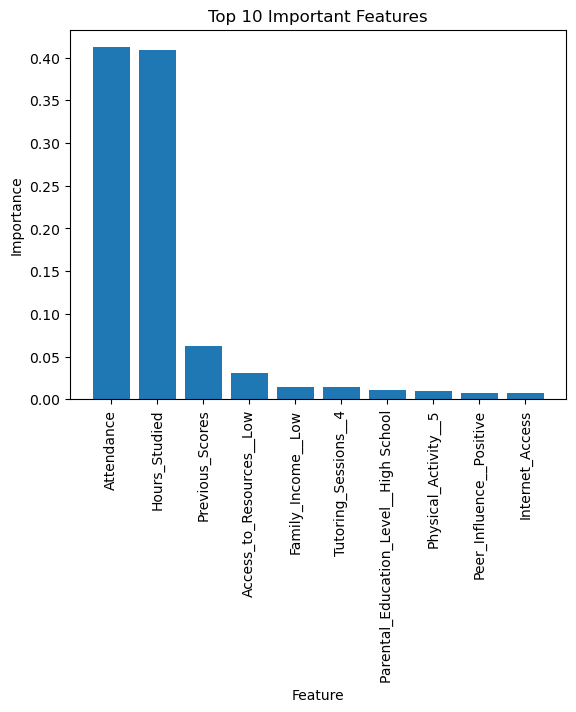

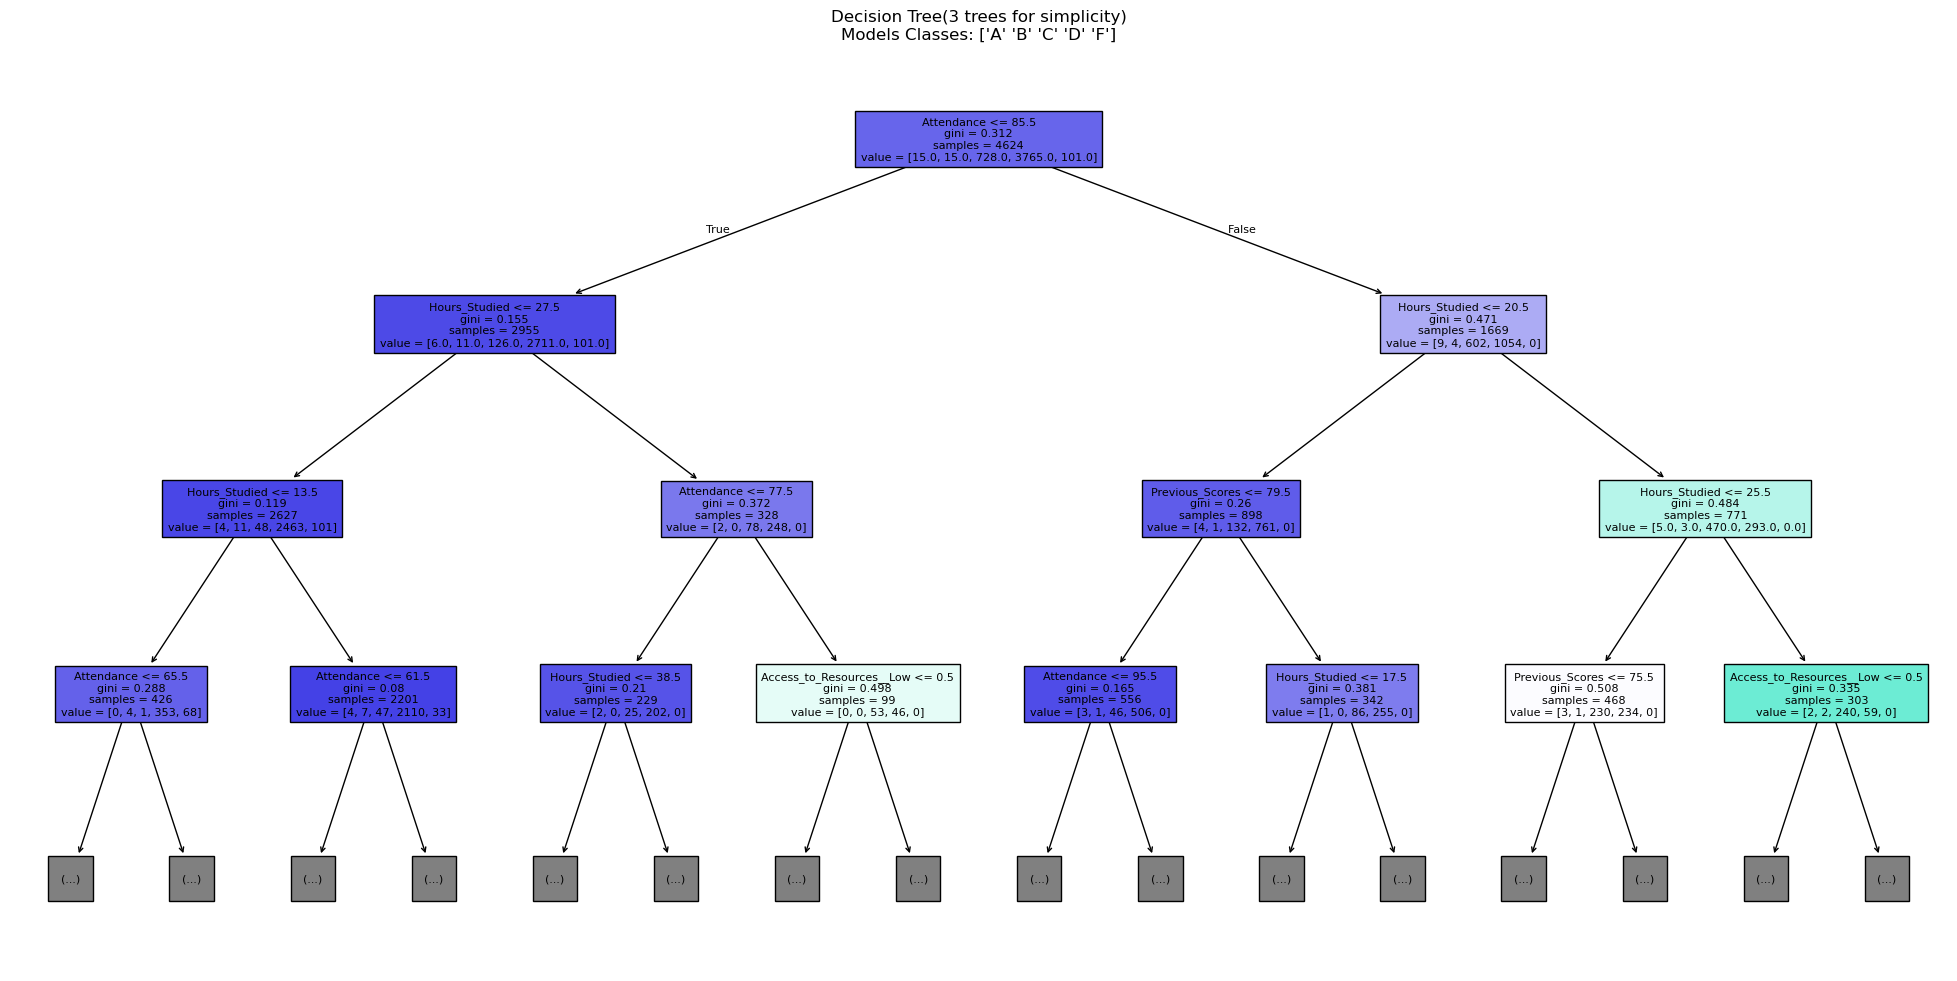


5 SGDClassifier()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgd__random_state,param_sgd__loss,param_sgd__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.189593,0.028022,0.007851,0.004758,42,log_loss,0.00010,"{'sgd__random_state': 42, 'sgd__loss': 'log_lo...",0.944865,0.967568,0.950270,0.968649,0.965368,0.959344,0.009823,1
6,0.120391,0.012815,0.003321,0.002107,42,hinge,0.00001,"{'sgd__random_state': 42, 'sgd__loss': 'hinge'...",0.935135,0.968649,0.957838,0.966486,0.956710,0.956964,0.011870,2
2,0.220011,0.007540,0.008343,0.009335,42,log_loss,0.00001,"{'sgd__random_state': 42, 'sgd__loss': 'log_lo...",0.935135,0.975135,0.953514,0.958919,0.951299,0.954800,0.012893,3
4,0.069595,0.015990,0.001905,0.001690,42,hinge,0.00100,"{'sgd__random_state': 42, 'sgd__loss': 'hinge'...",0.942703,0.960000,0.947027,0.963243,0.949134,0.952421,0.007860,4
8,0.095879,0.014856,0.002514,0.002244,42,log_loss,0.00100,"{'sgd__random_state': 42, 'sgd__loss': 'log_lo...",0.936216,0.962162,0.943784,0.955676,0.943723,0.948312,0.009316,5


Best model parameters for sgd: {'sgd__random_state': 42, 'sgd__loss': 'log_loss', 'sgd__alpha': 0.0001}
Best score: 0.9593

The LogisticRegression() model is the best model with a score of 0.973 using parameters: {'logreg__multi_class': 'multinomial', 'logreg__C': 10}


In [11]:
# Ensure model generalizes well to new data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# instantiate variables for best model score, model name, and parameters
best_score = 0
best_model = None
best_model_params = None

# Iterate through models, fit the model, perform hyperparameter tuning
i = 1
for model_name, model in models.items():
    print(i, model)
    steps = [
        ('scaler', StandardScaler()),
        (model_name, model)
    ] # Create steps for the pipeline model

    pipeline = Pipeline(steps)

    # Retreive models parameters
    param_grid = model_params.get(model_name)


    # Create random search and fit data to it
    random_search = RandomizedSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy', n_iter=10, random_state=42)
    random_search.fit(X_train, y_train)

    # Display df of result of random search
    df = pd.DataFrame(random_search.cv_results_)
    display(df.sort_values(by='rank_test_score').head())


    # Check if model score is highest to save model and its parameters
    model_score = random_search.best_score_
    
    if model_score > best_score:
        best_score = model_score
        best_model = model
        best_model_params = random_search.best_params_
    
    print(f"Best model parameters for {model_name}: {random_search.best_params_}")
    print(f"Best score: {(model_score).round(4)}")

    # Create plots if it is decision_tree model
    if model_name == 'decision_tree':
    #     # {'decision_tree__random_state': 42, 'decision_tree__max_depth': 5}
        best_params = {k.split("__")[1]: v for k, v in random_search.best_params_.items()}  # Extract correct param names
        clf = DecisionTreeClassifier(**best_params)  
        clf.fit(X_train, y_train)  # Train model

        # print(f"Feature Importances for Tree Model:\n{(clf.feature_importances_).round(2)}")
        # print(len(clf.feature_importances_))
        
        importance_indicies = np.argsort(clf.feature_importances_)[::-1][:10] #Get top 10 most important features indicies -> [ 1  0  3  8 32  4 42  9 22  6]
        
        plt.bar(X_train.columns[importance_indicies], clf.feature_importances_[importance_indicies])
        plt.xticks(rotation = 90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Top 10 Important Features")
        
        # Plot tree
        plt.figure(figsize=(25, 12))
        tree.plot_tree(clf, feature_names=X_train.columns, filled=True, rounded=False, fontsize = 8, max_depth = 3)
        plt.title(f"Decision Tree(3 trees for simplicity)\nModels Classes: {clf.classes_}")
        plt.show()

    print()
    i+=1


print(f"The {best_model} model is the best model with a score of {best_score.round(4)} using parameters: {best_model_params}")

As we can see, all the models performed quite well, however, the Logistic Regression model had the highest score at nearly 1. Lets now do some plotting to show the accuracy of the models predictions

In [12]:
# Instantiate model
best_model = LogisticRegression

In [13]:
# Format best model params
best_model_params = {k.split("__")[1]:v for k, v in best_model_params.items()}
best_model_params

{'multi_class': 'multinomial', 'C': 10}

In [14]:
# Set up pipeline model
model = best_model(**best_model_params)

steps = [
    ('scaler', StandardScaler()),
    ('model', model)
]

pipeline = Pipeline(steps)
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10, multi_class='multinomial'))])

In [15]:
# Fit model
pipeline.fit(X_train, y_train)

# Training and test score
print(f"Training Score: {pipeline.score(X_train, y_train)}")
print(f"Testing Score: {pipeline.score(X_test, y_test)}")
print()

# Print metric scores
print(f"Accuracy Score: {accuracy_score(y_test, pipeline.predict(X_test))}")
print(f"Precision Score: {precision_score(y_test, pipeline.predict(X_test), average='weighted')}")

Training Score: 0.9826989619377162
Testing Score: 0.9737638748738647

Accuracy Score: 0.9737638748738647
Precision Score: 0.967672018511024


C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ggpal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Create df's tp visualize predictions
df1 = pd.DataFrame({
    "Grade": y,
    "Actual_Test_Score" : [True] * len(y)
})

df2 = pd.DataFrame({
    "Grade": pipeline.predict(X),
    "Actual_Test_Score" : [False] * len(pipeline.predict(X))
})

In [17]:
predictions = pd.concat([df1, df2], axis = 0)
predictions

,Grade,Actual_Test_Score
0,D,True
1,D,True
2,C,True
3,C,True
4,D,True
...,...,...
6601,D,False
6602,D,False
6603,D,False
6604,D,False


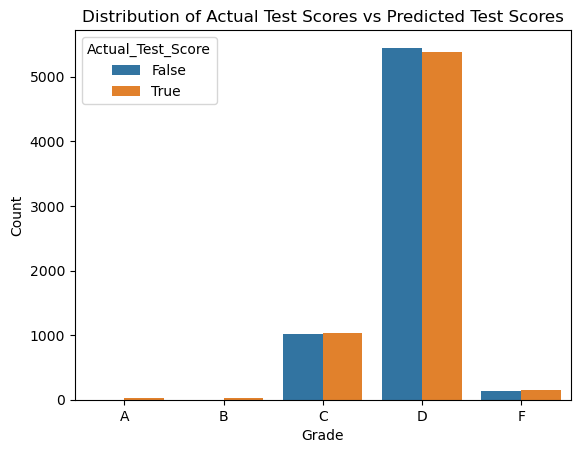

Grade Distribution of Actual Test Scores:
Grade
A      21
B      21
C    1040
D    5379
F     145
Name: count, dtype: int64

Grade Distribution of Predicted Test Scores:
Grade
C    1021
D    5448
F     137
Name: count, dtype: int64


In [29]:
# Plot counts using seaborn
g = sns.countplot(predictions, x = 'Grade', hue = 'Actual_Test_Score', order = ['A', 'B', 'C', 'D', 'F'])
g.set(xlabel = "Grade", ylabel = "Count")
plt.title("Distribution of Actual Test Scores vs Predicted Test Scores")
plt.show()

# Print out distributions
print(f"Grade Distribution of Actual Test Scores:\n{df1['Grade'].value_counts().sort_index(ascending=False)}")
print()
print(f"Grade Distribution of Predicted Test Scores:\n{df2.Grade.value_counts().sort_index(ascending=True)}")

In [20]:
# Compare right to wrong predictions
compare = y.values == pipeline.predict(X)
print(len(compare))
compare.astype(int).sum()

6606


6474

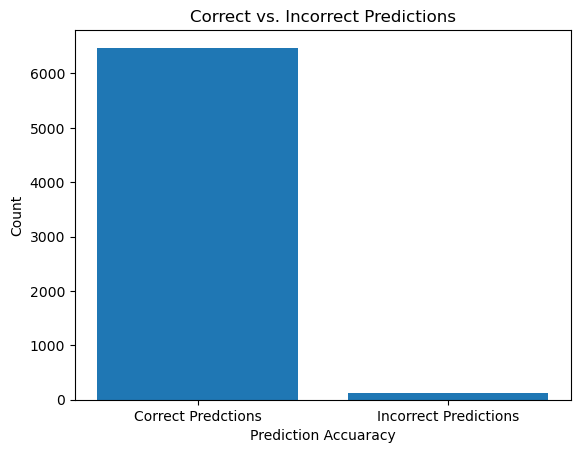

In [21]:
xlabs = ["Correct Predctions", "Incorrect Predictions"]
yvals = [compare.astype(int).sum(), 6606-compare.astype(int).sum()]

plt.bar(xlabs, yvals)
plt.xlabel("Prediction Accuaracy")
plt.ylabel("Count")
plt.title("Correct vs. Incorrect Predictions")
plt.show()

In [30]:
# Estimators/models 
# Logreg, KNN, SVC, Decision Tree
estimators = [
    ("logreg", LogisticRegression(multi_class = 'multinomial', C = 100)),
    ("KNN", KNeighborsClassifier(weights= 'distance', n_neighbors= 9)),
    ("SVC", SVC(gamma= 'auto', C= 10)),
    ("DT", DecisionTreeClassifier(max_depth = 6, random_state = 42))
]

# Instantiate voting class
vc = VotingClassifier(estimators, n_jobs = -1)

In [31]:
# Fit data
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('logreg',
                              LogisticRegression(C=100,
                                                 multi_class='multinomial')),
                             ('KNN',
                              KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance')),
                             ('SVC', SVC(C=10, gamma='auto')),
                             ('DT',
                              DecisionTreeClassifier(max_depth=6,
                                                     random_state=42))],
                 n_jobs=-1)

In [24]:
# Predict and Score
y_pred = vc.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(f'Accuracy Score: {acc_score}')
print(f"Testing Score: {vc.score(X_test, y_test)}")

Accuracy Score: 0.8965691220988901
Testing Score: 0.8965691220988901
